In [2]:
import pandas as pd
import spacy
import numpy as np
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from bs4 import BeautifulSoup

/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [3]:
df_articles = pd.read_csv('sävsjö_articles.csv')
df_articles.head()
df_articles = df_articles.dropna()
df_articles.head()

,ID,Title,Text
0,2,Aktiespararna säger ja till Gunvorbudet<span> ...,Aktiespararna rekommenderar sina medlemmar att...
2,7,Man fast i en timme i grop<span> - kuriren.nu<...,En man i 60-årsåldern föll ner i en grop som v...
3,8,Mannen fastnade i en grop  i flera timmar<spa...,En man i 60-årsåldern trillade ner i ett grävt...
4,56,En motorcykel,Här är den längre versionen.
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt. Då är det skö...


In [4]:
for col in df_articles.columns[1:]:
    df_articles[col] = df_articles[col].astype(str)
    df_articles[col] = df_articles[col].apply(lambda x: BeautifulSoup(x).get_text())
df_articles = df_articles.replace(r'[^\w\s]|_', '', regex=True)

/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [5]:
nlp = spacy.load("sv_core_news_sm")
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df_articles['Text']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [75]:
df_copy = df_articles.copy()
df_copy['tokens'] = tokens

In [ ]:
vocab = Dictionary(df_copy['tokens'])
vocab.token2id

In [67]:
vocab.filter_extremes(no_below=3, no_above=0.6, keep_n=500)

In [68]:
vocab.token2id

{'anse': 0,
 'lägga': 1,
 'medlem': 2,
 'rörvik': 3,
 'egen': 4,
 'meter': 5,
 'sävsjö': 6,
 'timme': 7,
 'tomt': 8,
 'hitta': 9,
 'stund': 10,
 'börja': 11,
 'helg': 12,
 'krona': 13,
 'vrigstad': 14,
 'claesson': 15,
 'elev': 16,
 'jobba': 17,
 'jönköping': 18,
 'klar': 19,
 'kommun': 20,
 'ny': 21,
 'stefan': 22,
 'drabba': 23,
 'kontakt': 24,
 'oklar': 25,
 'resa': 26,
 'ta': 27,
 'tid': 28,
 'trafik': 29,
 'förslag': 30,
 'förändring': 31,
 'gammal': 32,
 'genomföra': 33,
 'grupp': 34,
 'känd': 35,
 'lång': 36,
 'plan': 37,
 'välja': 38,
 'testa': 39,
 'ge': 40,
 'personal': 41,
 'vecka': 42,
 'bil': 43,
 'köra': 44,
 'morgon': 45,
 'polis': 46,
 'se': 47,
 'område': 48,
 'tisdag': 49,
 'upptäcka': 50,
 'företag': 51,
 'handla': 52,
 'kvinna': 53,
 'nära': 54,
 'avsluta': 55,
 'besök': 56,
 'chans': 57,
 'fortsätta': 58,
 'publik': 59,
 'scen': 60,
 'slut': 61,
 'start': 62,
 'svensson': 63,
 'träffa': 64,
 'tur': 65,
 'uppleva': 66,
 'år': 67,
 'besöka': 68,
 'dags': 69,
 'extra'

In [69]:
bagOfWords = [vocab.doc2bow(i) for i in df_copy['tokens']]

In [70]:
LDA_Model = LdaMulticore(corpus=bagOfWords, id2word=vocab, iterations=50, num_topics=5, workers = 4, passes=10)

In [96]:
LDA_Model.print_topics()


[(0,
  '0.053*"kommun" + 0.032*"sävsjö" + 0.022*"ta" + 0.019*"ny" + 0.019*"år" + 0.017*"stefan" + 0.016*"gustafsson" + 0.016*"se" + 0.014*"kommunstyrels" + 0.012*"ordförande"'),
 (1,
  '0.040*"polis" + 0.027*"bil" + 0.025*"plats" + 0.024*"sävsjö" + 0.021*"ta" + 0.021*"barn" + 0.019*"person" + 0.018*"väg" + 0.014*"kommun" + 0.013*"kvinna"'),
 (2,
  '0.022*"år" + 0.019*"se" + 0.018*"ta" + 0.018*"elev" + 0.018*"skola" + 0.018*"berätta" + 0.016*"jobba" + 0.015*"sävsjö" + 0.014*"ny" + 0.013*"företag"'),
 (3,
  '0.041*"år" + 0.023*"sävsjö" + 0.017*"ta" + 0.016*"berätta" + 0.015*"barn" + 0.013*"hel" + 0.012*"se" + 0.012*"ny" + 0.011*"spela" + 0.011*"gång"'),
 (4,
  '0.030*"kommun" + 0.027*"län" + 0.021*"sävsjö" + 0.019*"person" + 0.018*"se" + 0.017*"ta" + 0.014*"sverige" + 0.014*"region" + 0.013*"år" + 0.013*"procent"')]

,ID,Title,Text,tokens,topic
0,2,Aktiespararna säger ja till Gunvorbudet dise,Aktiespararna rekommenderar sina medlemmar att...,"[aktiespararna, rekommendera, medlem, anta, bu...",0
2,7,Man fast i en timme i grop kurirennu,En man i 60årsåldern föll ner i en grop som va...,"[föll, grop, grävd, egen, tomt, sävsjö, timme,...",3
3,8,Mannen fastnade i en grop i flera timmar exp...,En man i 60årsåldern trillade ner i ett grävt ...,"[trilla, grävt, hål, tomt, grop, stund, hitta]",3
4,56,En motorcykel,Här är den längre versionen,"[vara, version]",0
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt Då är det skön...,"[börja, vinter, kall, vara, skön, braskamin, u...",3
6,67,Sävsjö får ny skolchef,Sävsjö kommun ska få en ny skolchef Han heter ...,"[sävsjö, kommun, ny, skolchef, heta, stefan, c...",0
7,70,Krösatågen kan bli försenade,Ett signalfel på sträckan SödertäljeStockholm ...,"[signalfel, sträcka, södertäljestockholm, fred...",1
8,72,Sävsjöpensionärer gör uppror,Stora grupper av pensionärer i Sävsjö är på kr...,"[grupp, pensionär, sävsjö, vara, krigsstig, la...",0
9,78,Linus testar,Ett test jdklsa jfkldsa sjfkldsaö jfklsdaöjfls...,"[test, jdklsa, jfkldsa, sjfkldsaö, jfklsdaöjfl...",0
10,79,Linus testar 2,Testar 2,[testar],0


In [113]:
# Lemmatized articles as lists of tokens
lemmatized = df_copy['tokens'].tolist()

In [130]:
coherencemodel = CoherenceModel(model=LDA_Model, texts=lemmatized, dictionary=vocab, coherence='c_v')
baseline_coherence = coherencemodel.get_coherence()
print(f'Coherence value for baseline model: {baseline_coherence}')

Coherence value for baseline model: 0.38302633975504474


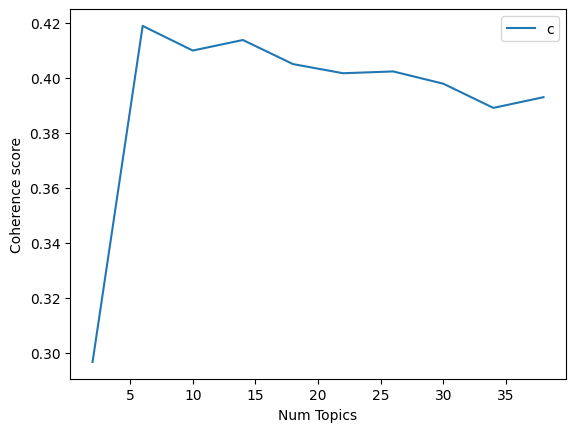

In [114]:
import matplotlib.pyplot as plt

# Compute coherence values for different numbers of topics 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=bagOfWords, id2word=vocab, iterations=50,chunksize= 200, num_topics= num_topics, workers = 4, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=vocab , corpus=bagOfWords, texts=lemmatized, start=2, limit=40, step=4)

# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [141]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
optimal_score = coherence_values[best_result_index]
diff_from_base = optimal_score - baseline_coherence


In [145]:
print(f'''Optimal number of topics for the LDA model: {x[best_result_index]}\nCoherence Score: {optimal_score}''')
print(f'Coherent improvement: {diff_from_base}')
# Get top topic for a specific bag-of-words formatted text
def top_topic(bow):
    topic_dict = {}
    for topic in bow:
        topic_dict[topic[0]]= topic[1]
    top_topic = sorted(topic_dict.items(),key=lambda x: x[1],reverse=True)[0][0]
    return top_topic

df_copy['topic'] = [top_topic(optimal_model[bagOfWords][i]) for i in range(len(df_copy['Text']))]
df_copy.head(15)

Optimal number of topics for the LDA model: 6
Coherence Score: 0.4189518475688469
Coherent improvement: 0.03592550781380216


,ID,Title,Text,tokens,topic
0,2,Aktiespararna säger ja till Gunvorbudet dise,Aktiespararna rekommenderar sina medlemmar att...,"[aktiespararna, rekommendera, medlem, anta, bu...",4
2,7,Man fast i en timme i grop kurirennu,En man i 60årsåldern föll ner i en grop som va...,"[föll, grop, grävd, egen, tomt, sävsjö, timme,...",1
3,8,Mannen fastnade i en grop i flera timmar exp...,En man i 60årsåldern trillade ner i ett grävt ...,"[trilla, grävt, hål, tomt, grop, stund, hitta]",1
4,56,En motorcykel,Här är den längre versionen,"[vara, version]",0
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt Då är det skön...,"[börja, vinter, kall, vara, skön, braskamin, u...",1
6,67,Sävsjö får ny skolchef,Sävsjö kommun ska få en ny skolchef Han heter ...,"[sävsjö, kommun, ny, skolchef, heta, stefan, c...",4
7,70,Krösatågen kan bli försenade,Ett signalfel på sträckan SödertäljeStockholm ...,"[signalfel, sträcka, södertäljestockholm, fred...",3
8,72,Sävsjöpensionärer gör uppror,Stora grupper av pensionärer i Sävsjö är på kr...,"[grupp, pensionär, sävsjö, vara, krigsstig, la...",4
9,78,Linus testar,Ett test jdklsa jfkldsa sjfkldsaö jfklsdaöjfls...,"[test, jdklsa, jfkldsa, sjfkldsaö, jfklsdaöjfl...",0
10,79,Linus testar 2,Testar 2,[testar],0


In [127]:
display = pyLDAvis.gensim_models.prepare(optimal_model, bagOfWords, optimal_model.id2word)
pyLDAvis.display(display)

/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
